In [1]:
data_location = 'sqlite:///../../../data/data.db'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

import pickle

In [3]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [4]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring=None
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [5]:
ohlc = pd.read_sql('SELECT * FROM ohlc', data_location)
ohlc.shape

(11627, 9)

In [6]:
ohlc.head()

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-11-01 00:00:00,61421.37,61669.14,61239.60,61343.68,256.433869,1.575751e+07,BTC,BTC
1,2021-11-01 01:00:00,61346.17,61709.82,61171.22,61610.93,332.481185,2.044558e+07,BTC,BTC
2,2021-11-01 02:00:00,61610.94,61779.87,61299.89,61333.17,314.250720,1.935390e+07,BTC,BTC
3,2021-11-01 03:00:00,61333.17,61457.28,60050.00,60589.06,1059.931358,6.414625e+07,BTC,BTC
4,2021-11-01 04:00:00,60590.23,60655.00,59752.92,59971.89,621.419878,3.744744e+07,BTC,BTC


In [7]:
tokens = ohlc.token.unique()

In [8]:
def df_merge(left, right):
    return pd.merge(left, right, on='ts', how='inner')

X = reduce(df_merge, [
    (lambda df: 
    (
        df
        .assign(
            ret=df.close.pct_change(), 
            osc=df.high / df.low - 1,
            ret2=df.close.pct_change(2),
            ret3=df.close.pct_change(3),
            ret6=df.close.pct_change(6),
        )[['ts', 'ret', 'osc', 'ret2', 'ret3', 'ret6', ]] 
        .rename(columns={
            col: f'{col}_{token}' for col in ['ts', 'ret', 'osc', 'ret2', 'ret3', 'ret6', ] if col != 'ts' 
        })
    ))(ohlc[ohlc.token == token])
    for token in tokens
]).set_index('ts')

In [9]:
y = X.ret_SOL.shift(-1)[:-1]
X = X[:-1]

In [10]:
X.tail()

,ret_BTC,osc_BTC,ret2_BTC,ret3_BTC,ret6_BTC,ret_ETH,osc_ETH,ret2_ETH,ret3_ETH,ret6_ETH,...,ret_AAVE,osc_AAVE,ret2_AAVE,ret3_AAVE,ret6_AAVE,ret_COMP,osc_COMP,ret2_COMP,ret3_COMP,ret6_COMP
ts,,,,,,,,,,,,,,,,,,,,,
2021-12-14 19:00:00,0.000402,0.010925,-0.001508,-0.004279,-0.018363,-0.002922,0.015699,-0.004080,-0.009777,-0.019864,...,-0.005855,0.023505,-0.007067,-0.003119,-0.015820,-0.011428,0.032641,-0.030221,-0.030168,-0.050533
2021-12-14 20:00:00,0.004810,0.009388,0.005215,0.003295,-0.006410,0.005961,0.009721,0.003021,0.001857,-0.006333,...,0.009387,0.016474,0.003477,0.002254,0.001034,0.006813,0.014268,-0.004693,-0.023614,-0.027668
2021-12-14 21:00:00,0.019797,0.022073,0.024702,0.025115,0.010595,0.016737,0.024448,0.022797,0.019808,0.004090,...,0.022490,0.030071,0.032088,0.026045,0.019762,0.017473,0.021116,0.024405,0.012698,-0.023269
2021-12-14 22:00:00,0.010414,0.019130,0.030417,0.035374,0.030944,0.004623,0.013961,0.021437,0.027526,0.017480,...,0.006242,0.015557,0.028872,0.038530,0.035291,0.009868,0.022673,0.027513,0.034514,0.003304
2021-12-14 23:00:00,-0.000302,0.009886,0.010109,0.030106,0.033500,-0.003195,0.010797,0.001413,0.018174,0.020064,...,-0.003013,0.010808,0.003210,0.025772,0.028084,-0.000864,0.012019,0.008995,0.026625,0.002383


Let's analyze our data a little bit

In [11]:
from pandas.plotting import scatter_matrix, autocorrelation_plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

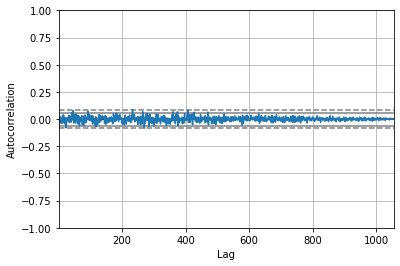

In [12]:
autocorrelation_plot(y[1:])

we can see that the hourly returns for aave doesn't have any strong autocorrelation

# Model Part

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import learning_curve

In [14]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]


In [15]:
def evaluate_model(model, X, y, test_size=0.2):
    cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
    scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    
    return np.mean(cross_validate(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)['test_score'])
    
#     scores = []
#     for train_idx, test_idx in cv.split(X):
#         X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
#         model.fit(X_train, y_train)
#         score = mean_squared_error(y_test, model.predict(X_test), squared=False)
#         scores.append(score)
        
#     return np.mean(scores)

In [16]:
pipeline = Pipeline([
    ('feature_selector', FeatureSelector(['ret_SOL'])),
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('model', Ridge(alpha=1.0))
])

evaluate_model(pipeline, X, y)

-0.008606772660645839

In [17]:
pipeline = Pipeline([
    ('feature_selector', FeatureSelector(['ret_SOL', 'ret2_SOL', 'ret3_SOL', 'ret6_SOL', ])), 
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('model', Ridge(alpha=1.0))
])

evaluate_model(pipeline, X, y)

-0.008612273578201537

In [18]:
pipeline = Pipeline([
    ('feature_selector', FeatureSelector(['ret_SOL', 'ret2_SOL', 'ret3_SOL', 'ret6_SOL','osc_SOL'])), 
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('model', Ridge(alpha=1.0))   
])

evaluate_model(pipeline, X, y)

-0.008571066960360429

In ridge models using only SOL features, it looks likes the best one.(without hyperparameter tuning) 

In [19]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('model', Ridge(alpha=1.0))
])

evaluate_model(pipeline, X, y)

-0.008682011499974064

In [20]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=22)),
    ('model', Ridge(alpha=1.0))
])

evaluate_model(pipeline, X, y)

-0.00852445756536349

In [21]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('pca', PCA(n_components=22)),
    ('model', Ridge(alpha=1.0))
])

evaluate_model(pipeline, X, y)

-0.008546772966408971

In ridge models using all features, the last 2 looks likes the best one.(without hyperparameter tuning)

In [22]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=30, random_state=0))
])

evaluate_model(pipeline, X, y)

-0.008755470756047273

In [23]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=22)),
    ('model', RandomForestRegressor(n_estimators=30, random_state=0))
])

evaluate_model(pipeline, X, y)

-0.008861119285173429

From above, ridge is better than Random Forest. Let's optimize the alpha parameter on the Ridge

In [24]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA()),
    ('model', Ridge())
])

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(pipeline, {
    'pca__n_components': [1, 5, 10, 20, 22, 30, 50,  ],
    'model__alpha': [0.1, 0.5,  1., 10., 100., 1000., ]
}, scoring=scorer, refit=True, cv=cv, n_jobs=-1)
search.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=211, test_size=1),
             estimator=Pipeline(steps=[('impute',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
                                       ('scale', StandardScaler()),
                                       ('pca', PCA()), ('model', Ridge())]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.1, 0.5, 1.0, 10.0, 100.0, 1000.0],
                         'pca__n_components': [1, 5, 10, 20, 22, 30, 50]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False))

In [25]:
search.best_params_

{'model__alpha': 100.0, 'pca__n_components': 30}

In [26]:
best_model = search.best_estimator_

In [27]:
evaluate_model(best_model, X, y)

-0.008460552213517884

Let's check the learning curve of our best model

<module 'matplotlib.pyplot' from 'D:\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

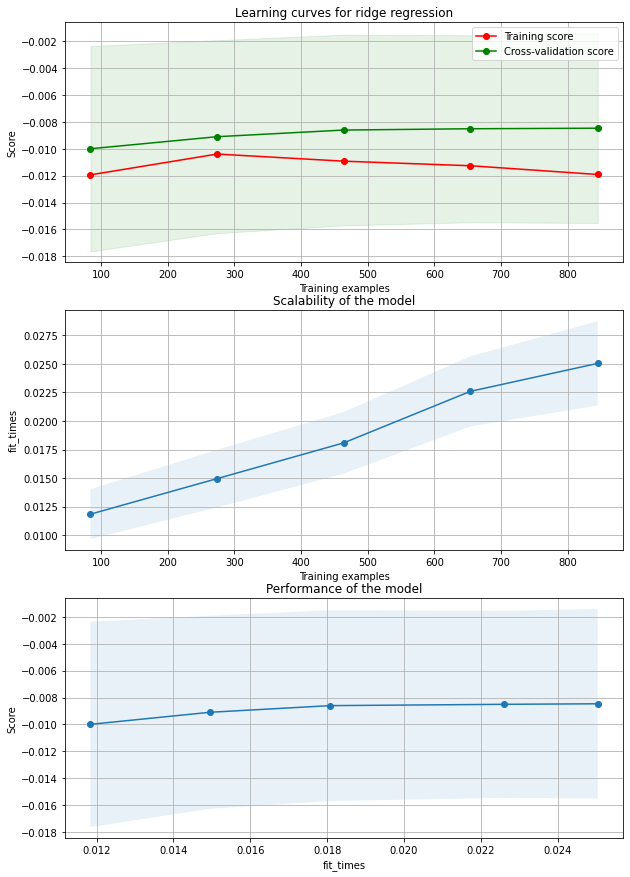

In [28]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Learning curves for ridge regression"

plot_learning_curve(
    best_model, title, X, y, axes=axes, cv=cv, n_jobs=4, scoring=scorer
)


Now that we have completed the model, we will need to save it down so that we can load it up in our model.  To do this, we will use pickle

In [29]:
pickle.dump(best_model, open('best_model.pkl', 'wb'))

We can verify that this is the same model that we saved:

In [30]:
loaded_model = pickle.load(open('best_model.pkl', 'rb'))

In [31]:
loaded_model == best_model

False

In [32]:
loaded_model.predict(X.iloc[[-1]])

array([-0.00292202])

In [33]:
best_model.predict(X.iloc[[-1]])

array([-0.00292202])

In [34]:
best_model

Pipeline(steps=[('impute', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scale', StandardScaler()), ('pca', PCA(n_components=30)),
                ('model', Ridge(alpha=100.0))])

In [35]:
loaded_model

Pipeline(steps=[('impute', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scale', StandardScaler()), ('pca', PCA(n_components=30)),
                ('model', Ridge(alpha=100.0))])

In [36]:
evaluate_model(best_model, X, y)

-0.008461701404604784

In [37]:
evaluate_model(loaded_model, X, y)

-0.008460993353072311

we can now take this model and build a server around it, so that other systems can also now make predictions on the hourly returns of SOL!